In [192]:
!pip install fastf1
!pip install pandas
!pip install numpy
!pip install scikit-learn
!pip install matplotlib
!pip install requests
!pip install torch


In [193]:
import os
os.makedirs("f1_cache", exist_ok=True)

In [194]:
import fastf1
import pandas as pd
import numpy as np
import requests
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer

fastf1.Cache.enable_cache("f1_cache")

# load the 2024 Monaco session data
session_2024 = fastf1.get_session(2024, 8, "R")
session_2024.load()
laps_2024 = session_2024.laps[["Driver", "LapTime", "Sector1Time", "Sector2Time", "Sector3Time"]].copy()
laps_2024.dropna(inplace=True)

# convert lap and sector times to seconds
for col in ["LapTime", "Sector1Time", "Sector2Time", "Sector3Time"]:
    laps_2024[f"{col} (s)"] = laps_2024[col].dt.total_seconds()

# aggregate sector times by driver
sector_times_2024 = laps_2024.groupby("Driver").agg({
    "Sector1Time (s)": "mean",
    "Sector2Time (s)": "mean",
    "Sector3Time (s)": "mean"
}).reset_index()

sector_times_2024["TotalSectorTime (s)"] = (
    sector_times_2024["Sector1Time (s)"] +
    sector_times_2024["Sector2Time (s)"] +
    sector_times_2024["Sector3Time (s)"]
)

# clean air race pace from racepace.py
clean_air_race_pace = {
    "VER": 93.191067, "HAM": 94.020622, "LEC": 93.418667, "NOR": 93.428600, "ALO": 94.784333,
    "PIA": 93.232111, "RUS": 93.833378, "SAI": 94.497444, "STR": 95.318250, "HUL": 95.345455,
    "OCO": 95.682128
}

# quali data from Monaco GP
qualifying_2025 = pd.DataFrame({
    "Driver": ["VER", "NOR", "PIA", "RUS", "SAI", "ALB", "LEC", "OCO",
               "HAM", "STR", "GAS", "ALO", "HUL"],
    "QualifyingTime (s)": [
        70.669,  # VER (1:10.669)
        69.954,  # NOR (1:09.954)
        70.129,  # PIA (1:10.129)
        None,    # RUS (DNF)
        71.362,  # SAI (1:11.362)
        71.213,  # ALB (1:11.213)
        70.063,  # LEC (1:10.063)
        70.942,  # OCO (1:10.942)
        70.382,  # HAM (1:10.382)
        72.563,  # STR (1:12.563)
        71.994,  # GAS (1:11.994)
        70.924,  # ALO (1:10.924)
        71.596   # HUL (1:11.596)
    ]
})
qualifying_2025["CleanAirRacePace (s)"] = qualifying_2025["Driver"].map(clean_air_race_pace)


core           INFO 	Loading data for Monaco Grand Prix - Race [v3.5.3]
INFO:fastf1.fastf1.core:Loading data for Monaco Grand Prix - Race [v3.5.3]
req            INFO 	Using cached data for session_info
INFO:fastf1.fastf1.req:Using cached data for session_info
req            INFO 	Using cached data for driver_info
INFO:fastf1.fastf1.req:Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
INFO:fastf1.fastf1.req:Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
INFO:fastf1.fastf1.req:Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
INFO:fastf1.fastf1.req:Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
INFO:fastf1.fastf1.req:Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
INFO:fastf1.fastf1.req:Using cached data for timing_app_data
core           

In [195]:

# get weather data for italy
# API_KEY = "YOUR_API_KEY"
# weather_url = f"http://api.openweathermap.org/data/2.5/forecast?lat=43.7384&lon=7.4246&appid={API_KEY}&units=metric"
# response = requests.get(weather_url)
# weather_data = response.json()
# print(weather_data)

In [196]:
import json

In [197]:
# with open("weather_data.txt", "w") as f:
#     json.dump(weather_data, f, indent=4)

with open("weather_data.txt", "r") as f:
    weather_data = json.load(f)

In [198]:
weather_data

{'cod': '200',
 'message': 0,
 'cnt': 40,
 'list': [{'dt': 1748293200,
   'main': {'temp': 18.44,
    'feels_like': 18.48,
    'temp_min': 15.72,
    'temp_max': 18.44,
    'pressure': 1016,
    'sea_level': 1016,
    'grnd_level': 1005,
    'humidity': 82,
    'temp_kf': 2.72},
   'weather': [{'id': 802,
     'main': 'Clouds',
     'description': 'scattered clouds',
     'icon': '03n'}],
   'clouds': {'all': 38},
   'wind': {'speed': 1.26, 'deg': 318, 'gust': 0.88},
   'visibility': 10000,
   'pop': 0,
   'sys': {'pod': 'n'},
   'dt_txt': '2025-05-26 21:00:00'},
  {'dt': 1748304000,
   'main': {'temp': 16.08,
    'feels_like': 15.94,
    'temp_min': 14.22,
    'temp_max': 16.08,
    'pressure': 1016,
    'sea_level': 1016,
    'grnd_level': 1004,
    'humidity': 84,
    'temp_kf': 1.86},
   'weather': [{'id': 803,
     'main': 'Clouds',
     'description': 'broken clouds',
     'icon': '04n'}],
   'clouds': {'all': 58},
   'wind': {'speed': 1.58, 'deg': 93, 'gust': 1.62},
   'visibili

In [199]:
import random
def set_seed(seed=37):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # if using GPU
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(37)

In [200]:
forecast_time = "2025-05-25 13:00:00"  # 15:00 CEST local time
forecast_data = next((f for f in weather_data["list"] if f["dt_txt"] == forecast_time), None)

rain_probability = forecast_data["pop"] if forecast_data else 0
temperature = forecast_data["main"]["temp"] if forecast_data else 20

# adjust qualifying time based on weather conditions
if rain_probability >= 0.75:
    qualifying_2025["QualifyingTime"] = qualifying_2025["QualifyingTime (s)"] * qualifying_2025["WetPerformanceFactor"]
else:
    qualifying_2025["QualifyingTime"] = qualifying_2025["QualifyingTime (s)"]

# add constructor's data
team_points = {
    "McLaren": 279, "Mercedes": 147, "Red Bull": 131, "Williams": 51, "Ferrari": 114,
    "Haas": 20, "Aston Martin": 14, "Kick Sauber": 6, "Racing Bulls": 10, "Alpine": 7
}
max_points = max(team_points.values())
team_performance_score = {team: points / max_points for team, points in team_points.items()}

driver_to_team = {
    "VER": "Red Bull", "NOR": "McLaren", "PIA": "McLaren", "LEC": "Ferrari", "RUS": "Mercedes",
    "HAM": "Mercedes", "GAS": "Alpine", "ALO": "Aston Martin", "TSU": "Racing Bulls",
    "SAI": "Ferrari", "HUL": "Kick Sauber", "OCO": "Alpine", "STR": "Aston Martin"
}

qualifying_2025["Team"] = qualifying_2025["Driver"].map(driver_to_team)
qualifying_2025["TeamPerformanceScore"] = qualifying_2025["Team"].map(team_performance_score)

# average position change at Monaco (quali pos - finish pos); positive means losing positions
average_position_change_monaco = {
    "VER": -1.0,
    "NOR": 1.0,
    "PIA": 0.2,
    "RUS": 0.5,
    "SAI": -0.3,
    "ALB": 0.8,
    "LEC": -1.5,
    "OCO": -0.2,
    "HAM": 0.3,
    "STR": 1.1,
    "GAS": -0.4,
    "ALO": -0.6,
    "HUL": 0.0
}
qualifying_2025["AveragePositionChange"] = qualifying_2025["Driver"].map(average_position_change_monaco)

# merge qualifying and sector times data
merged_data = qualifying_2025.merge(sector_times_2024[["Driver", "TotalSectorTime (s)"]], on="Driver", how="left")
merged_data["RainProbability"] = rain_probability
merged_data["Temperature"] = temperature
merged_data["QualifyingTime"] = merged_data["QualifyingTime"]


valid_drivers = merged_data["Driver"].isin(laps_2024["Driver"].unique())
merged_data = merged_data[valid_drivers]

# define features (X) and target (y)
X = merged_data[[
    "QualifyingTime", "RainProbability", "Temperature", "TeamPerformanceScore",
    "CleanAirRacePace (s)", "AveragePositionChange"
]]
y = laps_2024.groupby("Driver")["LapTime (s)"].mean().reindex(merged_data["Driver"])







In [201]:
# impute missing values for features
imputer = SimpleImputer(strategy="median")
X_imputed = imputer.fit_transform(X)

In [202]:
# train-test split
X_train, X_test, y_train, y_test = train_test_split(X_imputed, y, test_size=0.3, random_state=37)

In [203]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

# Convert train/test data to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).unsqueeze(1)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).unsqueeze(1)

# Wrap in DataLoader
train_ds = TensorDataset(X_train_tensor, y_train_tensor)
train_dl = DataLoader(train_ds, batch_size=8, shuffle=True)

# Define the neural network
class F1Net(nn.Module):
    def __init__(self, in_features):
        super(F1Net, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(in_features, 64),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 1)
        )

    def forward(self, x):
        return self.net(x)

# Initialize model
model = F1Net(X_train.shape[1])
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Train the model
model.train()
for epoch in range(200):  # Adjust epochs as needed
    for xb, yb in train_dl:
        pred = model(xb)
        loss = loss_fn(pred, yb)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()


In [204]:
model.eval()
with torch.no_grad():
    X_full_tensor = torch.tensor(X_imputed, dtype=torch.float32)
    preds = model(X_full_tensor).squeeze().numpy()
    merged_data["PredictedRaceTime (s)"] = preds

    # Evaluate on test set
    y_pred_test = model(X_test_tensor).squeeze()
    mae = nn.L1Loss()(y_pred_test, y_test_tensor.squeeze())
    print(f"Model Error (MAE): {mae.item():.2f} seconds")


Model Error (MAE): 0.74 seconds



🏁 Predicted 2025 Monaco GP Winner 🏁

   Driver  PredictedRaceTime (s)
0     NOR              78.510429
1     PIA              78.602959
2     LEC              78.638512
3     VER              78.774139
4     HAM              78.884697
5     RUS              78.964561
6     ALB              79.084435
7     ALO              79.417519
8     GAS              79.434105
9     SAI              79.595573
10    STR              80.214958
Model Error (MAE): 0.74 seconds


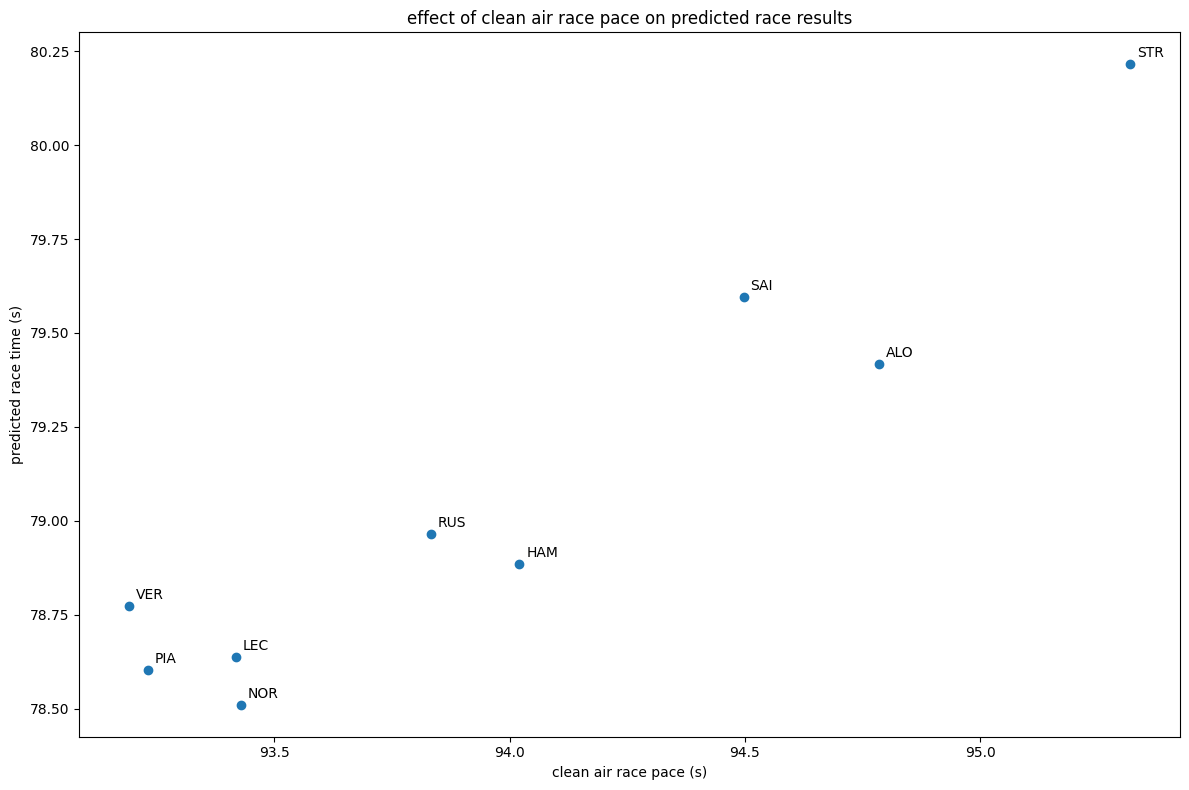


🏆 Predicted in the Top 3 🏆
🥇 P1: NOR
🥈 P2: PIA
🥉 P3: LEC


In [205]:
# ⏱️ Make predictions for all drivers
model.eval()
with torch.no_grad():
    X_full_tensor = torch.tensor(X_imputed, dtype=torch.float32)
    predictions = model(X_full_tensor).squeeze().numpy()
    merged_data["PredictedRaceTime (s)"] = predictions

# 🏁 Sort the results to find the predicted winner
final_results = merged_data.sort_values("PredictedRaceTime (s)").reset_index(drop=True)
print("\n🏁 Predicted 2025 Monaco GP Winner 🏁\n")
print(final_results[["Driver", "PredictedRaceTime (s)"]])

# 📊 Evaluate model on test set
y_pred_test = model(torch.tensor(X_test, dtype=torch.float32)).squeeze().detach().numpy()
print(f"Model Error (MAE): {mean_absolute_error(y_test, y_pred_test):.2f} seconds")

# 📈 Plot effect of clean air race pace
plt.figure(figsize=(12, 8))
plt.scatter(final_results["CleanAirRacePace (s)"], final_results["PredictedRaceTime (s)"])
for i, driver in enumerate(final_results["Driver"]):
    plt.annotate(driver,
                 (final_results["CleanAirRacePace (s)"].iloc[i], final_results["PredictedRaceTime (s)"].iloc[i]),
                 xytext=(5, 5), textcoords='offset points')
plt.xlabel("clean air race pace (s)")
plt.ylabel("predicted race time (s)")
plt.title("effect of clean air race pace on predicted race results")
plt.tight_layout()
plt.show()

# 🏆 Top 3 podium finishers
podium = final_results.loc[:2, ["Driver", "PredictedRaceTime (s)"]]
print("\n🏆 Predicted in the Top 3 🏆")
print(f"🥇 P1: {podium.iloc[0]['Driver']}")
print(f"🥈 P2: {podium.iloc[1]['Driver']}")
print(f"🥉 P3: {podium.iloc[2]['Driver']}")
